In [4]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from imblearn.ensemble import BalancedRandomForestClassifier

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Save models
import joblib

import random
random.seed(2024)

In [5]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
# Load data file
uq_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK5" 
train_x_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK5_binding_random_fold1_testY.csv")
test_x_df

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,5.994013,175.26022,9.389342,160.19148,12.411823,-2.771648,-0.577210,0.571201,2.757304,-0.052158,...,8.502358,131.625,39.500,16.500,4.875,0.000,0.000,2284,0.679245,2.566038
1,8.143989,172.74998,8.340377,158.41364,10.510427,-2.761202,-0.605943,0.736091,2.765514,-0.048581,...,11.167808,314.375,84.125,29.750,5.875,0.125,0.000,6535,0.780822,2.821918
2,7.558447,275.62744,10.419536,185.81779,15.728617,-2.267313,-0.722016,0.690390,2.228887,-0.064243,...,12.732143,115.250,17.500,6.000,2.125,0.000,0.000,1462,1.200000,3.885714
3,7.640180,209.40883,9.224951,131.75505,11.913830,-2.534188,-0.638915,0.706667,2.705784,-0.055374,...,9.086735,94.375,19.375,8.625,3.500,0.750,0.000,2904,0.877551,3.183673
4,10.034180,194.92766,11.159462,154.57048,14.929475,-2.472854,-0.686740,0.731408,2.491220,-0.059509,...,15.618902,214.250,54.125,22.500,6.500,0.875,0.000,1705,1.048780,3.560976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,9.364868,148.06656,9.751122,122.57384,11.608300,-2.537512,-0.599106,0.504315,2.707295,-0.041365,...,9.369318,173.875,60.000,29.625,13.875,5.125,0.375,4841,0.833333,2.787879
244,9.508312,134.60069,8.863824,177.13689,11.547717,-2.665385,-0.478010,0.442054,2.647204,-0.042139,...,9.153409,164.750,28.250,10.250,2.625,0.000,0.000,3842,0.969697,2.939394
245,8.014165,278.35916,9.845626,181.29170,13.266225,-2.441787,-0.582110,0.593952,2.439651,-0.046212,...,11.514151,157.250,27.875,10.250,3.000,0.125,0.000,3401,1.000000,3.433962
246,9.103675,200.99684,9.508262,174.29413,12.149082,-2.566612,-0.600858,0.577008,2.714610,-0.042108,...,8.604167,140.750,33.000,12.875,3.750,0.250,0.000,5121,0.909091,2.969697


In [7]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

print(train_x.shape)
print(train_y.shape)

(989, 306)
(989,)


In [8]:
# Construct a RF classification model

# creating a RF classifier
clf = BalancedRandomForestClassifier(n_estimators = 100, class_weight = "balanced")  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_x, train_y)
 
# performing predictions on the test dataset
train_pred_y = clf.predict(train_x)
test_pred_y = clf.predict(test_x)




/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silenc

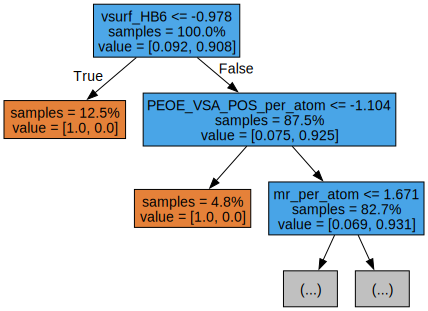

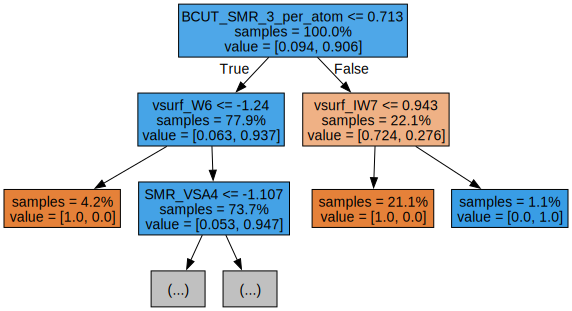

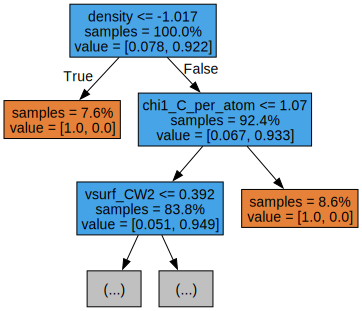

In [9]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[705 207]
 [  0  77]]


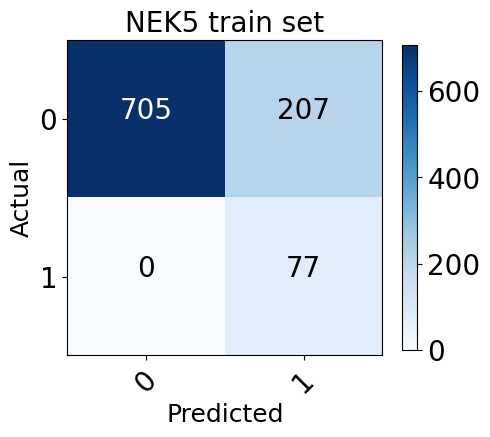

In [10]:
# Create the confusion matrix
train_cm = confusion_matrix(train_y, train_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 train set",fontsize=20)
plot_confusion_matrix(train_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


Confusion matrix, without normalization
[[169  59]
 [  6  14]]


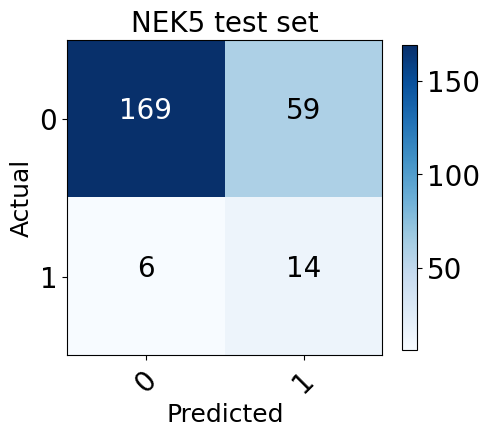

In [11]:
# Create the confusion matrix
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [12]:
# This takes a long time. Try loading the saved model.
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,80)}

# Create a random forest classifier
rf = BalancedRandomForestClassifier(class_weight = "balanced")

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silenc

RandomizedSearchCV(cv=5,
                   estimator=BalancedRandomForestClassifier(class_weight='balanced'),
                   n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x17b76aa00>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2c4635220>})

In [13]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Best hyperparameters: {'max_depth': 34, 'n_estimators': 336}

Best hyperparameters: {'max_depth': 52, 'n_estimators': 210}


In [14]:
# Save the best model

# save
joblib.dump(best_rf, "balanceRFC_randomCV_NEK5_binding.pkl") 

# load
#clf2 = joblib.load("balanceRFC_randomCV_NEK2_binding.pkl")
#clf2.predict(X[0:1])


['balanceRFC_randomCV_NEK5_binding.pkl']

Confusion matrix, without normalization
[[702 210]
 [  0  77]]


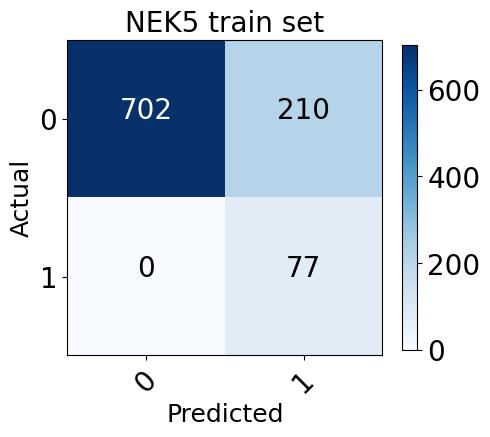

In [15]:
# Generate predictions with the best model
train_pred_y_best = best_rf.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 train set",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


Confusion matrix, without normalization
[[176  52]
 [  6  14]]


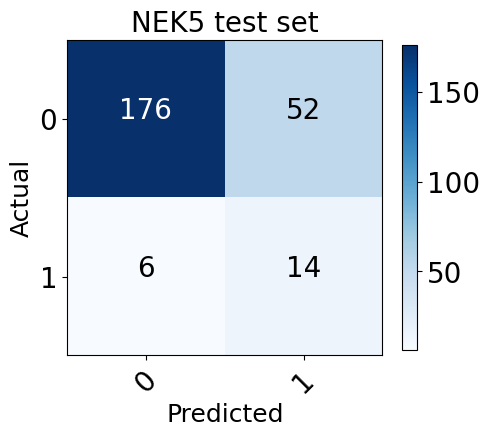

In [16]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [17]:
accuracy = accuracy_score(test_y, test_pred_y_best)
precision = precision_score(test_y, test_pred_y_best)
recall = recall_score(test_y, test_pred_y_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7661290322580645
Precision: 0.21212121212121213
Recall: 0.7


In [18]:
# This takes a very long time. Try load from the best model.
param_grid = {
    'n_estimators': np.linspace(100, 2000, 5, dtype = int),
    'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(train_x, train_y)



Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.2s
[CV] END max_depth=20, min_

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([ 100,  575, 1050, 1525, 2000])},
             verbose=2)

In [19]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 220,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [20]:
# Save the best model

# save
joblib.dump(best_rf_grid, "balanceRFC_gridCV_NEK5_binding.pkl") 

# load
#clf2 = joblib.load("balanceRFC_gridCV_NEK2_binding.pkl")
#clf2.predict(X[0:1])


['balanceRFC_gridCV_NEK5_binding.pkl']

Confusion matrix, without normalization
[[912   0]
 [ 18  59]]


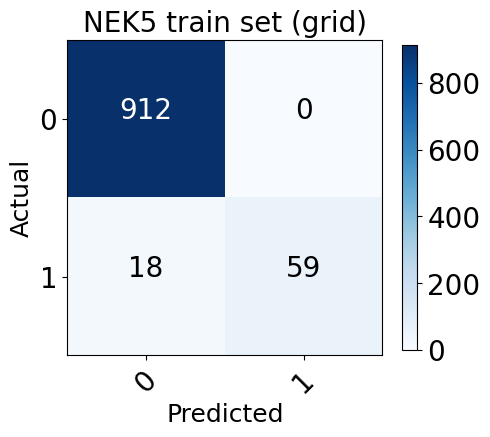

In [21]:
# Generate predictions with the best model
train_pred_y_best = best_rf_grid.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 train set (grid)",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[228   0]
 [ 15   5]]


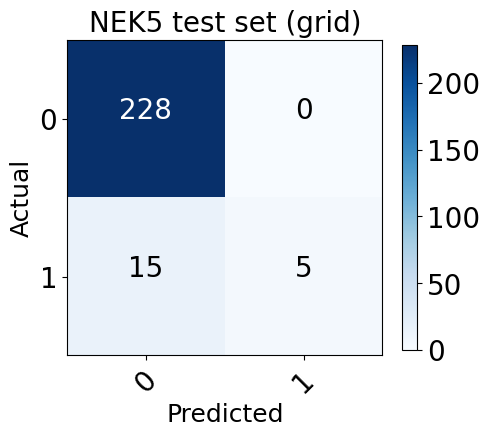

In [22]:
# Generate predictions with the best model
test_pred_y_best = best_rf_grid.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK5 test set (grid)",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

In [23]:
np.arange(len(best_rf_grid.estimators_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [24]:
# Tree predictions
train_proba0_df = pd.DataFrame()
train_proba1_df = pd.DataFrame()
test_proba0_df = pd.DataFrame()
test_proba1_df = pd.DataFrame()

for tree_num in np.arange(len(best_rf_grid.estimators_)):
    train_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(train_x)
    train_proba0_df[tree_num] = train_proba_temp[:,0]
    train_proba1_df[tree_num] = train_proba_temp[:,1]
    test_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(test_x)
    test_proba0_df[tree_num] = test_proba_temp[:,0]
    test_proba1_df[tree_num] = test_proba_temp[:,1]
    
train_proba0_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.0,1.000000,1.0,0.50,1.000000,1.000000,1.000000,0.000000,1.000000,...,1.000000,0.666667,1.000000,1.000000,1.00,1.0,1.000000,1.0,1.0,0.666667
1,1.000000,1.0,1.000000,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.142857,1.000000,1.000000,1.000000,1.00,1.0,1.000000,1.0,1.0,1.000000
2,1.000000,1.0,1.000000,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00,1.0,1.000000,0.0,1.0,1.000000
3,1.000000,1.0,1.000000,1.0,1.00,1.000000,0.666667,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.666667,1.00,1.0,1.000000,1.0,1.0,1.000000
4,1.000000,1.0,1.000000,1.0,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00,1.0,1.000000,1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,0.666667,0.0,0.666667,0.0,0.50,0.428571,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.833333,0.000000,1.00,0.0,0.000000,0.0,0.0,0.000000
985,0.400000,1.0,1.000000,1.0,0.25,0.428571,0.666667,0.333333,0.666667,0.000000,...,1.000000,0.000000,0.000000,0.750000,0.00,1.0,0.666667,1.0,1.0,0.000000
986,0.714286,0.0,0.000000,0.0,0.00,0.125000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.25,0.0,0.000000,0.0,0.0,1.000000
987,1.000000,0.0,0.600000,0.2,0.00,0.200000,0.333333,0.857143,0.800000,0.000000,...,0.000000,0.500000,0.000000,0.250000,1.00,0.0,0.000000,0.0,0.0,0.333333


In [25]:
std = test_proba0_df.std(axis=1)
std

0      0.389023
1      0.132861
2      0.106397
3      0.211257
4      0.122774
         ...   
243    0.416691
244    0.322840
245    0.418910
246    0.461311
247    0.253232
Length: 248, dtype: float64

In [43]:
# Empty dataframe
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

# Predictions
train_perf_df['train_y_pred_grid'] = train_pred_y_best
test_perf_df['test_y_pred_grid'] = test_pred_y_best

# Actual
train_perf_df['train_y'] = train_y
test_perf_df['test_y'] = test_y

# Variances
train_perf_df['train_proba0_std_grid'] = train_proba0_df.std(axis=1)
train_perf_df['train_proba1_std_grid'] = train_proba1_df.std(axis=1)
test_perf_df['test_proba0_std_grid'] = test_proba0_df.std(axis=1)
test_perf_df['test_proba1_std_grid'] = test_proba1_df.std(axis=1)

train_perf_df


,train_y_pred_grid,train_y,train_proba0_std_grid,train_proba1_std_grid
0,0,0,0.213870,0.213870
1,0,0,0.115775,0.115775
2,0,0,0.142928,0.142928
3,0,0,0.157242,0.157242
4,0,0,0.081513,0.081513
...,...,...,...,...
984,1,1,0.378220,0.378220
985,1,1,0.419401,0.419401
986,1,1,0.413095,0.413095
987,1,1,0.428497,0.428497


In [27]:
test_perf_df

,test_y_pred_grid,test_y,test_proba0_std_grid,test_proba1_std_grid
0,0,0,0.389023,0.389023
1,0,0,0.132861,0.132861
2,0,0,0.106397,0.106397
3,0,0,0.211257,0.211257
4,0,0,0.122774,0.122774
...,...,...,...,...
243,1,1,0.416691,0.416691
244,0,1,0.322840,0.322840
245,0,1,0.418910,0.418910
246,0,1,0.461311,0.461311


In [28]:

categories = []

for index, row in test_perf_df.iterrows():
    true = row['test_y']
    pred = row['test_y_pred_grid']
    
    if true == 0 and pred == 0:
        categories.append('6') # True Negative
    elif true == 1 and pred == 0: 
        categories.append('7') # False Negative
    elif true == 1 and pred == 1: 
        categories.append('8') # True Positive
    elif true == 0 and pred == 1:
        categories.append('9') # False Positive

test_perf_df['category'] = categories



In [29]:

categories = []

for index, row in test_perf_df.iterrows():
    true = row['test_y']
    pred = row['test_y_pred_grid']
    
    if true == 0 and pred == 0:
        categories.append('6') # True Negative
    elif true == 1 and pred == 0: 
        categories.append('7') # False Negative
    elif true == 1 and pred == 1: 
        categories.append('8') # True Positive
    elif true == 0 and pred == 1:
        categories.append('9') # False Positive

test_perf_df['category'] = categories

test_perf_df['category'] = categories
test_perf_df['test_proba0_std_grid'] = test_perf_df['test_proba0_std_grid']

print(test_perf_df)


     test_y_pred_grid  test_y  test_proba0_std_grid  test_proba1_std_grid  \
0                   0       0              0.389023              0.389023   
1                   0       0              0.132861              0.132861   
2                   0       0              0.106397              0.106397   
3                   0       0              0.211257              0.211257   
4                   0       0              0.122774              0.122774   
..                ...     ...                   ...                   ...   
243                 1       1              0.416691              0.416691   
244                 0       1              0.322840              0.322840   
245                 0       1              0.418910              0.418910   
246                 0       1              0.461311              0.461311   
247                 0       1              0.253232              0.253232   

    category  
0          6  
1          6  
2          6  
3          6  


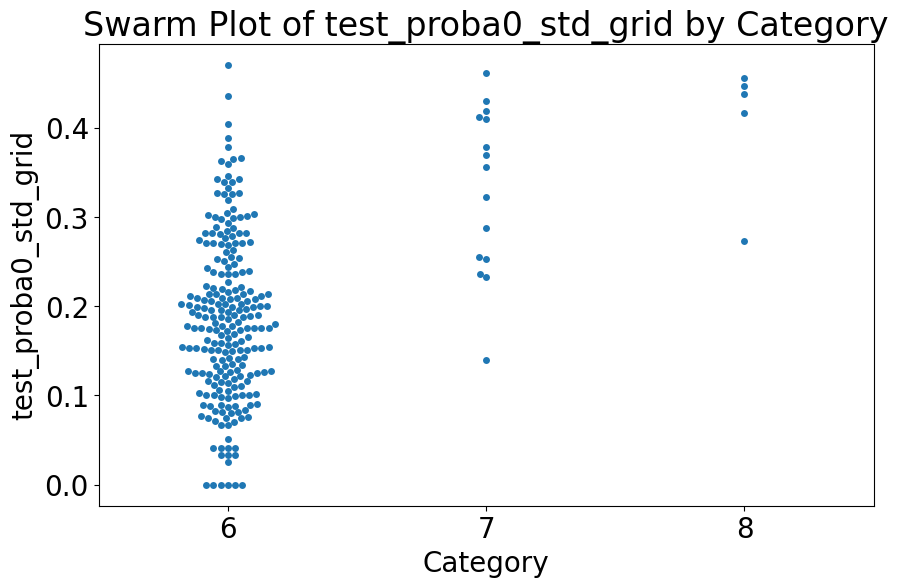

In [30]:

import seaborn as sns
import matplotlib.pyplot as plt

# Create the swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='category', y='test_proba0_std_grid', data=test_perf_df)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('test_proba0_std_grid')
plt.title('Swarm Plot of test_proba0_std_grid by Category')

# Show plot
plt.show()


In [44]:

# Convert probability to variance
test_perf_df['test_variance_grid'] = test_perf_df['test_proba1_std_grid'] * (1 - test_perf_df['test_proba1_std_grid'])

print(test_perf_df)


     test_y_pred_grid  test_y  test_proba0_std_grid  test_proba1_std_grid  \
0                   0       0              0.389023              0.389023   
1                   0       0              0.132861              0.132861   
2                   0       0              0.106397              0.106397   
3                   0       0              0.211257              0.211257   
4                   0       0              0.122774              0.122774   
..                ...     ...                   ...                   ...   
243                 1       1              0.416691              0.416691   
244                 0       1              0.322840              0.322840   
245                 0       1              0.418910              0.418910   
246                 0       1              0.461311              0.461311   
247                 0       1              0.253232              0.253232   

     test_variance_grid  
0              0.237684  
1              0.115209

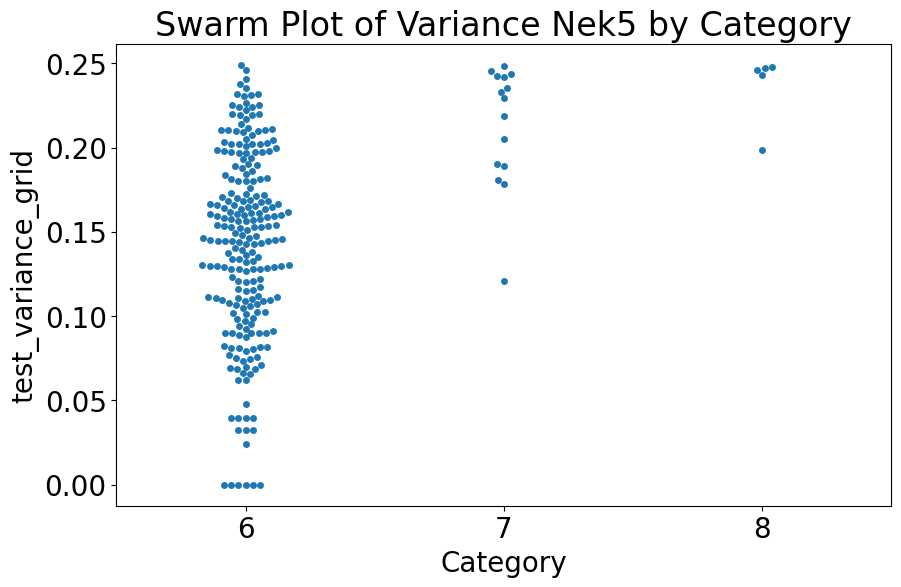

In [48]:
categories = []

for index, row in test_perf_df.iterrows():
    true = row['test_y']
    pred = row['test_y_pred_grid']
    
    if true == 0 and pred == 0:
        categories.append('6') # True Negative
    elif true == 1 and pred == 0: 
        categories.append('7') # False Negative
    elif true == 1 and pred == 1: 
        categories.append('8') # True Positive
    elif true == 0 and pred == 1:
        categories.append('9') # False Positive

test_perf_df['category'] = categories

# Now, let's plot with the updated DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Create the swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='category', y='test_variance_grid', data=test_perf_df)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('test_variance_grid')
plt.title('Swarm Plot of Variance Nek5 by Category')

# Show plot
plt.show()


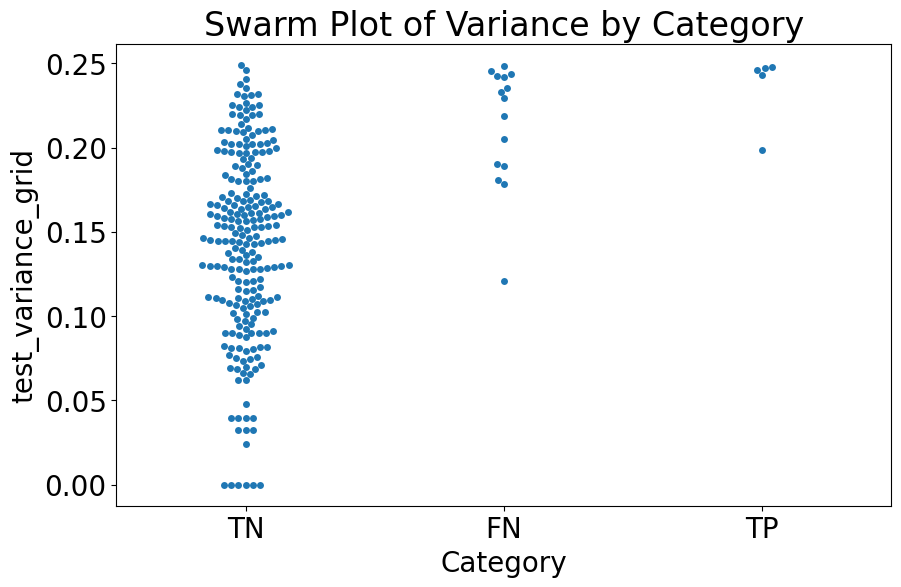

In [49]:
# Define custom labels for x-axis
custom_labels = {'6': 'TN', '7': 'FN', '8': 'TP', '9': 'FP'}

# Create the swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='category', y='test_variance_grid', data=test_perf_df)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('test_variance_grid')
plt.title('Swarm Plot of Variance by Category')

# Set custom labels for x-axis
plt.xticks(ticks=plt.xticks()[0], labels=[custom_labels[label.get_text()] for label in plt.gca().get_xticklabels()])

# Show plot
plt.show()